# Lab:  Nonlinear Least Squares for Modeling Materials

Nonlinear least squares (NLLS) is a widely-used method for modeling data.  In NLLS, we wish to fit a model of the form,

     yhat = g(x,w)
     
where `w` is a vector of paramters and `x` is the vector of predictors.  We find `w` by minimizing a least-squares function 

     f(w) = \sum_i (y_i - g(x_i,w))^2
     
where the summation is over training samples `(x_i,y_i)`.  This is similar to linear least-squares, but the function `g(x,w)` may not be linear in `w`.  In general, this optimization has no closed-form expression.  So numerical optimization must be used.  

In this lab, we will implement gradient descent on NLLS in a problem of physical modeling of materials.  Specifically, we will estimate parameters for expansion of copper as a function of temperature using a real dataset.  In doing this lab, you will learn to:
* Set up a nonlinear least squares as an unconstrained optimization function
* Compute initial parameter estimates for a simple rational model
* Compute the gradients of the least squares objective
* Implement gradient descent for minimizing the objective
* Implement momentum gradient descent
* Visualize the convergence of the algorithm

We first import some key packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LinearRegression

## Load the Data

The NIST agency has an excellent [nonlinear regression website](https://www.itl.nist.gov/div898/strd/nls/nls_main.shtml) that has several datasets for nonlinear regression problems.  In this lab, we will use the data from a NIST study involving the thermal expansion of copper. The response variable is the coefficient of thermal expansion, and the predictor variable is temperature in degrees kelvin.  

> Hahn, T., NIST (1979), Copper Thermal Expansion Study.  (unpublished}

You can download the data as follows.

In [2]:
url = 'https://itl.nist.gov/div898/strd/nls/data/LINKS/DATA/Hahn1.dat'
df = pd.read_csv(url, skiprows=60, sep=' ',skipinitialspace=True, names=['y0','x0','dummy'])
df.head()

,y0,x0,dummy
0,0.591,24.41,NaN
1,1.547,34.82,NaN
2,2.902,44.09,NaN
3,2.894,45.07,NaN
4,4.703,54.98,NaN


Extract the `x0` and `y0` into arrays.  Rescale, `x0` and `y0` to values between `0` and `1` by dividing `x0` and `y0` by the maximum value.  Store the scaled values in vectors `x` and `y`.  The rescaling will help with the conditioning of the fitting.  Plot, `y` vs. `x`. 

Text(0, 0.5, 'Predictor Variable in Kelvin')

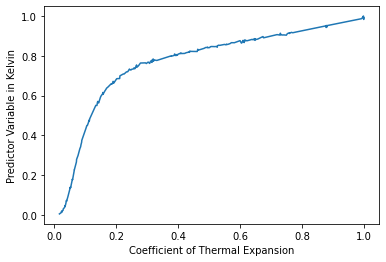

In [3]:
# TODO 1
x0 = np.array(df['x0'])
y0 = np.array(df['y0'])
x = x0/np.max(x0)
y = y0/np.max(y0)
args=np.argsort(x)
x=x[args]
y=y[args]
plt.plot(x,y)
plt.xlabel('Coefficient of Thermal Expansion')
plt.ylabel('Predictor Variable in Kelvin')

To make the problem a little more challenging, we will add some noise.  Add random Gaussian noise with mean 0 and std. dev = 0.02 to `y`.  Store the noisy results in `yn`. You can use the `np.random.normal()` function to add Gaussian noise. Plot `yn` vs. `x`.

Text(0, 0.5, 'Predictor Variable in Kelvin')

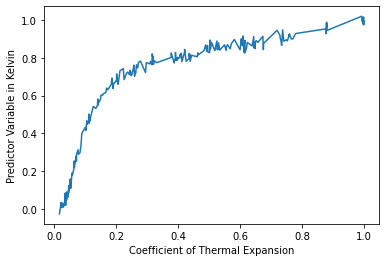

In [4]:
# TODO 2
yn= y + np.random.normal(0,0.02,y.shape)
plt.plot(x,yn)
plt.xlabel('Coefficient of Thermal Expansion')
plt.ylabel('Predictor Variable in Kelvin')

Split the data `(x,yn)` into training and test.  Let `xtr,ytr` be training data and `xts,yts` be the test data.  You can use the `train_test_split` function.  Set `test_size=0.33` so that 1/3 of the samples are held out for test.

In [5]:
from sklearn.model_selection import train_test_split

# TODO 3
xtr, xts, ytr, yts =train_test_split(x, yn, test_size=0.33,shuffle=True)
args=np.argsort(xtr)
args_t=np.argsort(xts)
xtr=xtr[args]
ytr=ytr[args]
xts=xts[args_t]
yts=yts[args_t]

## Initial Fit for a Rational Model

The [NIST website](https://www.itl.nist.gov/div898/strd/nls/data/hahn1.shtml) suggests using a *rational* model of the form,

      yhat = (a[0] + a[1]*x + ... + a[d]*x^d)/(1 + b[0]*x + ... + b[d-1]*x^d)
      
with `d=3`.  The model parameters are `w = [a[0],...,a[d],b[0],...,b[d-1]]` so there are `2d+1` parameters total.    Complete the function below that takes vectors `w` and `x` and predicts a set of values `yhat` using the above model.
   

In [6]:
import numpy.polynomial.polynomial as poly
def predict(w,x):
    
    # Get the length
    d = (len(w)-1)//2
    
    # TODO 4.  Extract a and b from w
    a = w[:d+1]
    b = w[d+1:]
    a=np.flip(a)
    b=np.append(np.flip(b),1)
    # TODO 5.  Compute yhat.  You may use the np.polyval function
    # But, remember you must flip the order the a and b
    yhat=np.polyval(a,x)/(np.polyval(b,x))
    
    return yhat

When we fit with a nonlinear model, most methods only get convergence to a local minima.  So, you need a good initial condition.  For a rational model, one way to get is to realize that if:


    y ~= (a[0] + a[1]*x + ... + a[d]*x^d)/(1 + b[0]*x + ... + b[d-1]*x^d)
    
Then:

    y ~= a[0] + a[1]*x + ... + a[d]*x^d - b[0]*x*y + ... - b[d-1]*x^d*y.
    
So, we can solve for the the parameters `w = [a,b]` from linear regression of the predictors,

    Z[i,:] = [ x[i], ... , x[i]**d, y[i]*x[i], ... , y[i}*x[i]**d ] 

In [7]:
d = 3

# TODO 6.  Create the transformed feature matrix
dp = np.arange(1,d+1)
Z = np.zeros((len(xtr),2*d))
for i in range(len(xtr)):
    Z[i,:]=np.concatenate((np.power(xtr[i],dp),ytr[i]*np.power(xtr[i],dp)))


# TODO 7.  Fit with parameters with linear regression
regr = LinearRegression()
regr.fit(Z,ytr)
# TODO 8
# Extract the parameters from regr.coef_ and regr.intercept_ and store the parameter vector in winit
a=np.append([regr.intercept_],regr.coef_[0:d])
b=-regr.coef_[d:]
winit=np.append(a,b)

Now plot the predicted values of the `yhat` vs. `x` using your estimated parameter `winit` for 1000 values `x` in `[0,1]`.  On the same plot, plot `yts` vs. `xts`.  You will see that you get a horrible fit.

(0.0, 1.0)

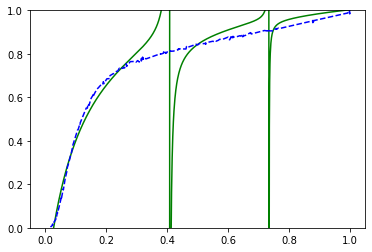

In [8]:
# TODO 9
xp = np.linspace(0,1,1000)
yhat = predict(winit,xp)
plt.plot(xp,yhat,'g',x,y,'b--')
plt.ylim([0,1])



The reason the previous fit is poor is that the denominator in `yhat` goes close to zero.   To avoid this problem, we can use Ridge regression, to try to keep the parameters close to zero.  Re-run the fit above with `Ridge` with `alpha = 1e-3`. You should see you get a reasonable, but not perfect fit.

(0.0, 1.0)

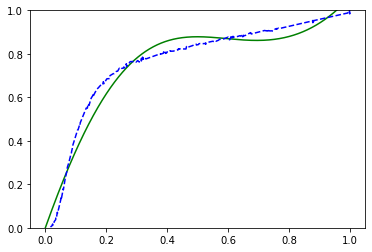

In [9]:
# TODO 10.  Fit with parameters with linear regression
rigregr=Ridge(alpha=1e-3)
rigregr.fit(Z,ytr)


# TODO 11
# Extract the parameters from regr.coef_ and regr.intercept_
a=np.concatenate(([rigregr.intercept_],rigregr.coef_[0:d]))
b=-rigregr.coef_[d:]
winit=np.append(a,b)
xp=np.linspace(0,1,1000)
yhat=predict(winit,xp)

# TODO 12
# Plot the results as above.
plt.plot(xp,yhat,'g',x,y,'b--')
plt.ylim(0,1.0)


## Creating a Loss Function

We can now use gradient descent to improve our initial estimate.  Complete the following function to compute

    f(w) = 0.5*\sum_i (y[i] - yhat[i])^2
    
and `fgrad`, the gradient of `f(w)`.

In [10]:
def feval(w,x,y):
        
    
    # TODO 13.  Parse w
    d=(len(w)-1)//2
    a=w[0:d+1]
    b=w[d+1:]
    
    # TODO 14.  Znum[i,j] = x[i]**j
    Znum=np.zeros((len(x),d+1))
    for j in range(d+1):
        Znum[:,j]=x[:]**j
    # TODO 15.  Zden[i,j] = x[i]**(j+1)
    Zden = np.zeros((len(x),d))
    for j in range(d):
        Zden[:,j]=x[:]**(j+1)
    
    
    
    # TODO 16.  Compute yhat 
    yhat=np.zeros(len(x))
    for i in range(len(x)):
        yhat[i]=Znum[i,:].dot(a)/(1+Zden[i,:].dot(b))
    # Compute the numerator and denominator
    
    
    
    # TODO 17.  Compute loss
    f=0.5 *np.sum(np.square(y-yhat))
    
    #TODO 18 Compute gradients
    grada=np.zeros(len(a))
    for j in range(len(a)):
        grada[j]=-np.sum((y-yhat)*Znum[:,j]/(1+np.matmul(Zden,b)))
        gradb=np.zeros(len(b))
    for j in range(len(b)):
        gradb[j]=np.sum((y-yhat)*yhat*Zden[:,j]/(1+np.matmul(Zden,b)))
        
        
    fgrad=np.concatenate((grada,gradb))
    
        
        
        
            
    
    return f, fgrad


Test the gradient function:
* Take `w0=winit` and compute `f0,fgrad0 = feval(w0,xtr,ytr)`
* Take `w1` very close to `w0` and compute `f1,fgrad1 = feval(w1,xtr,ytr)`
* Verify that `f1-f0` is close to the predicted value based on the gradient.

In [11]:
#TODO 19
w0=winit
f0,fgrad0=feval(w0,xtr,ytr)
r1 = 1e-6
w1=w0+r1
f1,fgrad1=feval(w1,xtr,ytr)
print("Predicted f1-f0 =%12.4e"%(fgrad0.dot(w1-w0)))
print("Actual f1-f0 =%12.4e"%(f1-f0))

Predicted f1-f0 = -2.1801e-07
Actual f1-f0 = -2.1790e-07


## Implement gradient descent

We will now try to minimize the loss function with gradient descent.  Using the function `feval` defined above, implement gradient descent.  Run gradient descent with a step size of `alpha=1e-6` starting at `w=winit`.  Run it for `nit=10000` iterations.  Compute `fgd[it]`= the objective function on iteration `it`.  Plot `fgd[it]` vs. `it`.  

You should see that the training loss decreases, but it still hasn't converged after 10000 iterations.

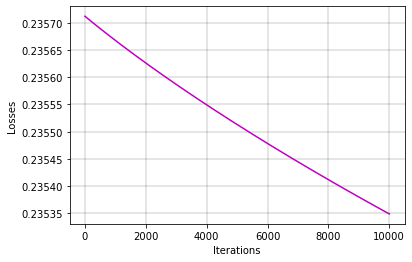

In [12]:
# TODO 20
fgd = np.zeros(10000)
nit = 10000
step = 1e-6
hist={'w':[],'f':[]}
for i in range(nit):
    f0,fgrad0=feval(w0,xtr,ytr)
    w0=w0-fgrad0*step
    hist['w'].append(w0)
    hist['f'].append(f0)
loss=np.array(hist['f'])
plt.plot(loss,'m-')
plt.xlabel('Iterations')
plt.ylabel('Losses')
plt.grid(color='k', linewidth=0.2)


    


Now, try to get a faster convergence with adaptive step-size using the Armijo rule. Implement the gradient descent with adaptive step size.  Let `fadapt[it]` be the loss function on iteration `it`.  Plot `fadapt[it]` and `fgd[it]` vs. `it` on the same graph.  You should see a slight improvement, but not much.

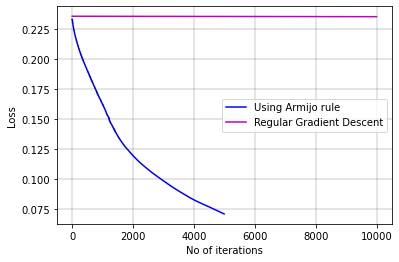

In [13]:
# TODO 21
# fadapt = ...
nit = 10000
step = 1e-6  # Initial step
hist={'w':[],'f':[]}
w0=winit
f0,fgrad0=feval(winit,xtr,ytr)
for i in range(nit):
    w1=w0-fgrad0*step
    f1,fgrad1=feval(w1,xtr,ytr)
    df=fgrad0.dot(w1-w0)
    a1=0.5
    if(f1-f0 < a1*df) and (f1<f0):
        step=step*2
        f0=f1
        fgrad0=fgrad1
        w0=w1
    else:
        step=step/2
        hist['w'].append(w0)
        hist['f'].append(f0)
loss_arm=np.array(hist['f'])
plt.plot(loss_arm,'b-')
plt.plot(loss,'m-')
plt.xlabel('No of iterations')
plt.ylabel('Loss')
plt.grid(color='k',linewidth=0.2)
plt.gca().legend(('Using Armijo rule','Regular Gradient Descent'))

Using he final estimate for `w` from the adaptive step-size plot the predicted values of the `yhat` vs. `x` usfor 1000 values `x` in `[0,1]`.  On the same plot, plot `yhat` vs. `x` for the initial parameter `w=winit`.  Also, plot `yts` vs. `xts`.  You should see that gradient descent was able to improve the estimat slightly, although the initial estimate was not too bad.

(0.0, 1.0)

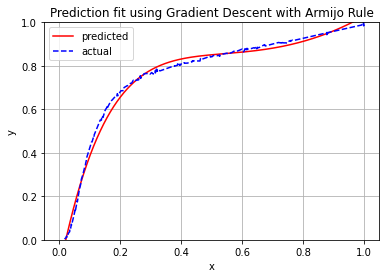

In [14]:
# TODO 22
# xp = np.linspace(...)
# yhat = ...
# plot(...)
w_adapt_fin=np.array(hist['w'])[4990,:]
xp=np.linspace(0,1,1000)
yhat=predict(w_adapt_fin,xp)
plt.plot(xp,yhat,'r')
plt.plot(x,y,'b--')
plt.xlabel('x')
plt.ylabel('y')
plt.gca().legend(('predicted','actual'))
plt.title('Prediction fit using Gradient Descent with Armijo Rule')
plt.grid()
plt.ylim(0,1)

## Momentum Gradient Descent

This section is bonus.

One way to improve gradient descent is to use *momentum*.  In momentum gradient descent, the update rule is:

    f, fgrad = feval(w,...)
    z = beta*z + fgrad
    w = w - step*z
    
This is similar to gradient descent, except that there is a second order term on the gradient.  Implement this algorithm with `beta = 0.99` and `step=1e-3`.   Compare the convergence of the loss function with gradient descent.  

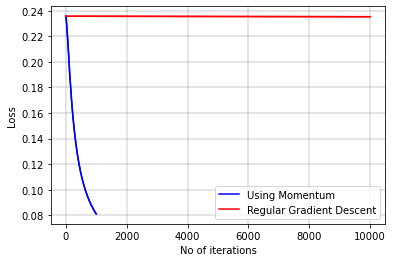

In [15]:
# TODO 23
nit = 1000
step = 1e-3
beta = 0.99
z=np.zeros(np.shape(winit))
hist={'w':[],'f':[]}
w0=winit
for i in range(nit):
    f0,fgrad0= feval(w0,xtr,ytr)
    z=z*beta+fgrad0
    w0=w0-z*step
    hist['w'].append(w0)
    hist['f'].append(f0)
loss_mom=np.array(hist['f'])
plt.plot(loss_mom,'b-')
plt.plot(loss,'r-')
plt.plot(loss_mom,'b-')
plt.plot(loss,'r-')
plt.xlabel('No of iterations')
plt.ylabel('Loss')
plt.grid(color='k',linewidth=0.2)
plt.gca().legend(('Using Momentum','Regular Gradient Descent'))
plt.xlabel('No of iterations')
plt.ylabel('Loss')
plt.grid(color='k',linewidth=0.2)
plt.gca().legend(('Using Momentum','Regular Gradient Descent'))

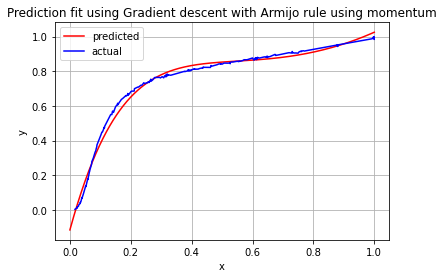

In [16]:
# TODO 24
# plot yhat vs. x
w_mom=np.array(hist['w'])[999,:]
xp=np.linspace(0,1,num=1000)
yhat=predict(w_mom,xp)
plt.plot(xp,yhat,'r')
plt.plot(x,y,'b')
plt.xlabel('x')
plt.ylabel('y')
plt.gca().legend(('predicted','actual'))
plt.title('Prediction fit using Gradient descent with Armijo rule using momentum')
plt.grid()

## Beyond This Lab
In this lab, we have just touched at some of the ideas in optimization.  There are several other important algorithms that you can explore:
* [Levenberg-Marquardt](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm) method for non-linear least squares
* Newton's method
* More difficult non-linear least squares problems.